### Imports and paths

In [65]:
import pandas as pd
import geopandas as gpd

COLLISIONS_PATH = "../data/raw/collisions/tps_collisions.geojson"
NBHD_PATH = "../data/raw/boundaries/toronto_neighbourhoods.geojson"

print("Ready")


Ready


### Loading the GeoJSONs

In [66]:
coll = gpd.read_file(COLLISIONS_PATH)
nbhd = gpd.read_file(NBHD_PATH)

print("Collisions shape:", coll.shape)
print("Neighbourhoods shape:", nbhd.shape)

coll.head()


Collisions shape: (790725, 22)
Neighbourhoods shape: (158, 12)


,OBJECTID,EVENT_UNIQUE_ID,OCC_DATE,OCC_MONTH,OCC_DOW,OCC_YEAR,OCC_HOUR,DIVISION,FATALITIES,INJURY_COLLISIONS,...,HOOD_158,NEIGHBOURHOOD_158,LONG_WGS84,LAT_WGS84,AUTOMOBILE,MOTORCYCLE,PASSENGER,BICYCLE,PEDESTRIAN,geometry
0,1,GO-20148000012,"Wed, 01 Jan 2014 05:00:00 GMT",January,Wednesday,2014,18,D41,0,NO,...,126,Dorset Park (126),-79.281097,43.765821,YES,NO,NO,NO,NO,POINT (-79.2811 43.76582)
1,2,GO-20148002064,"Wed, 01 Jan 2014 05:00:00 GMT",January,Wednesday,2014,17,D32,0,NO,...,050,Newtonbrook East (50),-79.415990,43.781633,YES,NO,NO,NO,NO,POINT (-79.41599 43.78163)
2,3,GO-20141260499,"Wed, 01 Jan 2014 05:00:00 GMT",January,Wednesday,2014,2,NSA,0,YES,...,NSA,NSA,0.000000,0.000000,YES,NO,NO,NO,NO,POINT (5.68434e-14 5.08889e-14)
3,4,GO-20141260663,"Wed, 01 Jan 2014 05:00:00 GMT",January,Wednesday,2014,3,NSA,0,NO,...,NSA,NSA,0.000000,0.000000,YES,NO,NO,NO,NO,POINT (5.68434e-14 5.08889e-14)
4,5,GO-20141261162,"Wed, 01 Jan 2014 05:00:00 GMT",January,Wednesday,2014,5,NSA,0,YES,...,NSA,NSA,0.000000,0.000000,YES,NO,NO,NO,NO,POINT (5.68434e-14 5.08889e-14)


### Inspecting columns

In [67]:
print("Collision columns:\n", list(coll.columns))
print("\nNeighbourhood columns:\n", list(nbhd.columns))


Collision columns:
 ['OBJECTID', 'EVENT_UNIQUE_ID', 'OCC_DATE', 'OCC_MONTH', 'OCC_DOW', 'OCC_YEAR', 'OCC_HOUR', 'DIVISION', 'FATALITIES', 'INJURY_COLLISIONS', 'FTR_COLLISIONS', 'PD_COLLISIONS', 'HOOD_158', 'NEIGHBOURHOOD_158', 'LONG_WGS84', 'LAT_WGS84', 'AUTOMOBILE', 'MOTORCYCLE', 'PASSENGER', 'BICYCLE', 'PEDESTRIAN', 'geometry']

Neighbourhood columns:
 ['_id', 'AREA_ID', 'AREA_ATTR_ID', 'PARENT_AREA_ID', 'AREA_SHORT_CODE', 'AREA_LONG_CODE', 'AREA_NAME', 'AREA_DESC', 'CLASSIFICATION', 'CLASSIFICATION_CODE', 'OBJECTID', 'geometry']


In [68]:
#Quality check to confirm toronto lat and long
coll[["LONG_WGS84", "LAT_WGS84"]].describe()

,LONG_WGS84,LAT_WGS84
count,790725.000000,790725.000000
mean,-66.420439,36.571237
std,29.352303,16.161439
min,-79.639247,0.000000
25%,-79.444834,43.644548
50%,-79.370118,43.693049
75%,-79.258814,43.751658
max,0.000000,43.853164


### Ensuring CRS consistency

In [69]:
print("Collisions CRS:", coll.crs)
print("Neighbourhoods CRS:", nbhd.crs)

#forcing both to EPSG:4326
if coll.crs is None:
    coll = coll.set_crs("EPSG:4326")
else:
    coll = coll.to_crs("EPSG:4326")

if nbhd.crs is None:
    nbhd = nbhd.set_crs("EPSG:4326")
else:
    nbhd = nbhd.to_crs("EPSG:4326")

print("After fix -> Collisions CRS:", coll.crs)
print("After fix -> Neighbourhoods CRS:", nbhd.crs)


Collisions CRS: EPSG:4326
Neighbourhoods CRS: EPSG:4326
After fix -> Collisions CRS: EPSG:4326
After fix -> Neighbourhoods CRS: EPSG:4326


### Cleaning geometries to avoid join failures

In [70]:
#keeping only points with valid geometry
coll = coll[coll.geometry.notnull()].copy()
coll = coll[coll.geometry.is_valid].copy()

#neighbourhood polygons valid
nbhd = nbhd[nbhd.geometry.notnull()].copy()
nbhd = nbhd[nbhd.geometry.is_valid].copy()

print("After geometry clean -> Collisions:", coll.shape, "Neighbourhoods:", nbhd.shape)


After geometry clean -> Collisions: (790725, 22) Neighbourhoods: (158, 12)


### Creating a proper date column

In [71]:
[c for c in coll.columns if "date" in c.lower() or "time" in c.lower()]

['OCC_DATE']

In [72]:
DATE_COL = "OCC_DATE"

coll[DATE_COL] = pd.to_datetime(coll[DATE_COL], errors="coerce")
coll = coll.dropna(subset=[DATE_COL]).copy()

coll["date"] = coll[DATE_COL].dt.date

coll[["date", DATE_COL]].head()


,date,OCC_DATE
0,2014-01-01,2014-01-01 05:00:00
1,2014-01-01,2014-01-01 05:00:00
2,2014-01-01,2014-01-01 05:00:00
3,2014-01-01,2014-01-01 05:00:00
4,2014-01-01,2014-01-01 05:00:00


#### Identified that roughly 131k rows disappeared after the below spatial join. Did some basic diagnosis noticed a "null island problem" after the below spatial join since unmatched joins show (0,0) coordinates which is outside Canada : clearly indication of bad data. So refining the code a bit before the spatial join and tweaking coordinates to be a tighter fit for toronto (roughly 43.5 to 43.9 N, -79.65 to -79.1 W)

### Correcting Workflow

In [73]:
#visualizing the bad data count before dropping
zeros_mask = (coll["LONG_WGS84"] == 0) | (coll["LAT_WGS84"] == 0)
print(f"Rows with (0,0) coordinates: {zeros_mask.sum()}")

#applying the bounding box filter

#previously hard coded the bounds:
#toronto fits roughly within: Lat 43.5-43.9, Long -79.65 to -79.1
"""coll_clean = coll[
    (coll["LAT_WGS84"].between(43.5, 43.9)) &
    (coll["LONG_WGS84"].between(-79.7, -79.1))
].copy()"""

#now computing them from neighbourhood polygons so filter is data driven
minx, miny, maxx, maxy = nbhd.total_bounds
coll_clean = coll[
    coll["LAT_WGS84"].between(miny, maxy) &
    coll["LONG_WGS84"].between(minx, maxx)
].copy()


print(f"Original count: {len(coll)}")
print(f"Clean count: {len(coll_clean)}")
print(f"Dropped {len(coll) - len(coll_clean)} invalid points")



Rows with (0,0) coordinates: 129190
Original count: 790725
Clean count: 661535
Dropped 129190 invalid points


### Spatial join: collision points -> neighbourhood polygons

In [74]:
#before modfication
"""joined = gpd.sjoin(
    coll,
    nbhd,
    how="inner",
    predicate="within"
)"""

#after modification now running the spatial join on 'coll_clean'
joined = gpd.sjoin(
    coll_clean,
    nbhd,
    how="inner",
    predicate="within"
)

print("Joined shape:", joined.shape)
joined.head()


Joined shape: (659398, 35)


,OBJECTID_left,EVENT_UNIQUE_ID,OCC_DATE,OCC_MONTH,OCC_DOW,OCC_YEAR,OCC_HOUR,DIVISION,FATALITIES,INJURY_COLLISIONS,...,AREA_ID,AREA_ATTR_ID,PARENT_AREA_ID,AREA_SHORT_CODE,AREA_LONG_CODE,AREA_NAME,AREA_DESC,CLASSIFICATION,CLASSIFICATION_CODE,OBJECTID_right
0,1,GO-20148000012,2014-01-01 05:00:00,January,Wednesday,2014,18,D41,0,NO,...,2502334,26022849,None,126,126,Dorset Park,Dorset Park (126),Emerging Neighbourhood,EN,17825249.0
1,2,GO-20148002064,2014-01-01 05:00:00,January,Wednesday,2014,17,D32,0,NO,...,2502233,26022748,None,050,050,Newtonbrook East,Newtonbrook East (50),Not an NIA or Emerging Neighbourhood,NA,17826865.0
13,14,GO-20148004780,2014-01-01 05:00:00,January,Wednesday,2014,14,D32,0,NO,...,2502245,26022760,None,031,031,Yorkdale-Glen Park,Yorkdale-Glen Park (31),Emerging Neighbourhood,EN,17826673.0
14,15,GO-20148004875,2014-01-01 05:00:00,January,Wednesday,2014,14,D32,0,NO,...,2502313,26022828,None,105,105,Lawrence Park North,Lawrence Park North (105),Not an NIA or Emerging Neighbourhood,NA,17825585.0
15,16,GO-20148050012,2014-01-01 05:00:00,January,Wednesday,2014,13,D41,0,NO,...,2502334,26022849,None,126,126,Dorset Park,Dorset Park (126),Emerging Neighbourhood,EN,17825249.0


### Diagnosing why the join dropped 131k collisions

In [75]:
#before diagnosis
#dropped by join
"""drop_rate = 1 - (len(joined) / len(coll))
drop_rate"""

#after diagnosis
drop_rate = 1 - (len(joined) / len(coll_clean))
drop_rate

0.003230365740285901

In [76]:
#before diagnosis
#points that did not match any neighbourhood
"""unmatched = coll_c.loc[~coll.index.isin(joined.index)].copy()
unmatched[[ "LONG_WGS84", "LAT_WGS84" ]].describe()"""

#after diagnosis
unmatched = coll_clean.loc[~coll_clean.index.isin(joined.index)].copy()
unmatched[[ "LONG_WGS84", "LAT_WGS84" ]].describe()


,LONG_WGS84,LAT_WGS84
count,2137.000000,2137.000000
mean,-79.395579,43.797639
std,0.141907,0.046419
min,-79.639247,43.588898
25%,-79.543389,43.770952
50%,-79.383396,43.806101
75%,-79.267901,43.832727
max,-79.219111,43.844027


#### To explore predicate = "intersects" instead of "within" in gdp.sjoin.

### Comparison : "within" vs "intersects"

In [77]:
#running the join with intersects to see what we gain
joined_intersects = gpd.sjoin(
    coll_clean,
    nbhd,
    how="inner",
    predicate="intersects"
)

# comparing the counts
count_within = len(joined)
count_intersects = len(joined_intersects)
diff = count_intersects - count_within

#checking for duplicates
#If a crash is on the border, it might be assigned to both neighborhoods
dupe_count = joined_intersects.index.duplicated().sum()

print(f"Matches with 'within':     {count_within}")
print(f"Matches with 'intersects': {count_intersects}")
print(f"Net gain in rows:          {diff}")
print(f"Duplicate assignments:     {dupe_count}")

#smart Decision Logic
# If we gain points but create duplicates, we usually want to keep the points
# but arbitrarily assign them to just one neighbourhood to avoid double counting.
if diff > 0:
    print("\n'intersects' captured more points. Switching to it...")
    #dropping duplicates so a single crash doesn't count for two areas
    joined = joined_intersects[~joined_intersects.index.duplicated(keep='first')].copy()
    print("Duplicates dropped. Updated 'joined' dataframe.")
else:
    print("\nNo significant difference. Keeping original 'within' join.")

Matches with 'within':     659398
Matches with 'intersects': 659398
Net gain in rows:          0
Duplicate assignments:     0

No significant difference. Keeping original 'within' join.


#### Got a boring in the best possible way result above. Se for now sticking to "within" instead of "intersects" since it is computationally faster and also proved accurate for this dataset

### Aggregating to daily neighbourhood counts

In [78]:
nbhd.columns


Index(['_id', 'AREA_ID', 'AREA_ATTR_ID', 'PARENT_AREA_ID', 'AREA_SHORT_CODE',
       'AREA_LONG_CODE', 'AREA_NAME', 'AREA_DESC', 'CLASSIFICATION',
       'CLASSIFICATION_CODE', 'OBJECTID', 'geometry'],
      dtype='str')

In [79]:
NBHD_ID_COL = "AREA_ID"
NBHD_NAME_COL = "AREA_NAME"


In [80]:
daily = (
    joined.groupby(["date", NBHD_ID_COL, NBHD_NAME_COL])
    .size()
    .reset_index(name="collision_count")
)

daily.head(), daily.shape


(         date  AREA_ID                      AREA_NAME  collision_count
 0  2014-01-01  2502209                  Humber Summit                1
 1  2014-01-01  2502213         West Humber-Clairville                1
 2  2014-01-01  2502218  Kingsview Village-The Westway                1
 3  2014-01-01  2502222             Princess-Rosethorn                1
 4  2014-01-01  2502227            Stonegate-Queensway                1,
 (362550, 4))

### Temporal sanity check as a visualization

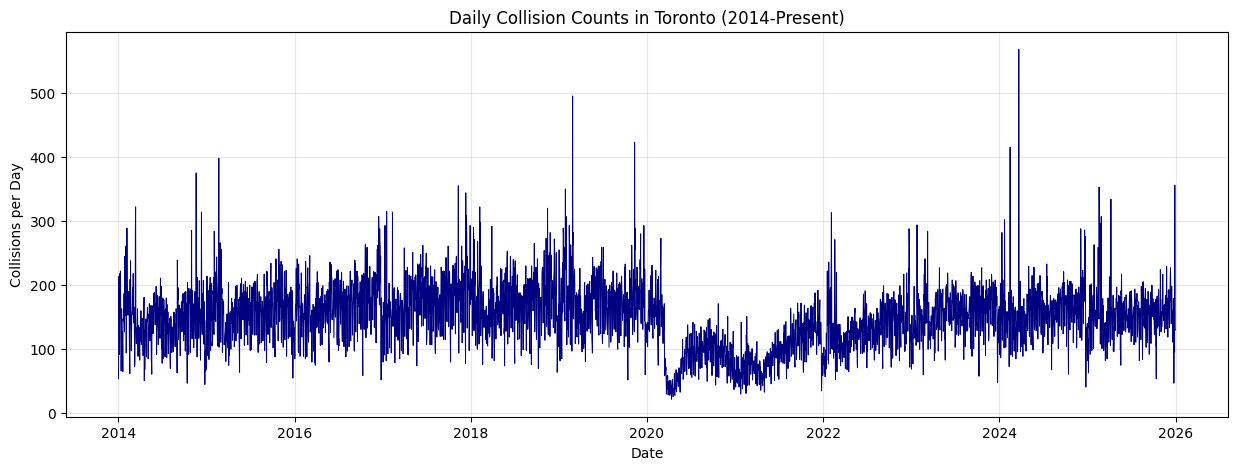

In [81]:
import matplotlib.pyplot as plt

#plot of total collisions per day
daily_total = joined.groupby("date").size()

plt.figure(figsize=(15, 5))
daily_total.plot(title="Daily Collision Counts in Toronto (2014-Present)", color='navy', linewidth=0.7)
plt.ylabel("Collisions per Day")
plt.xlabel("Date")
plt.grid(True, alpha=0.3)
plt.show()

#### Dip observed near March 2020 due to COVID. There's a rhythmic pattern to the data and mega spikes indicating extreme events. Possibly major ice storms or snow evens. Not removing these as outliers since it is important for a risk model.

### Output save

In [82]:
OUT_PATH = "../data/interim/collisions_nbhd_daily.parquet"
daily.to_parquet(OUT_PATH, index=False)

print("Saved:", OUT_PATH)


Saved: ../data/interim/collisions_nbhd_daily.parquet
